In [267]:

import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge, SGDClassifier
from sklearn.metrics import precision_score, r2_score
from sklearn.model_selection import (cross_val_score, cross_validate,
                                     train_test_split)
from statsmodels.regression.linear_model import OLS

# http://archive.ics.uci.edu/ml/datasets/Wine+Quality
np.random.seed(42)


In [268]:
data = pd.read_csv('http://cs.if.uj.edu.pl/piotrek/ML2019/datasets/dataset_2.txt')

data.info()
# data['make']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 26 columns):
horsepower           205 non-null float64
highway-mpg          205 non-null float64
symboling            205 non-null float64
normalized-losses    205 non-null float64
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null float64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null float64
fuel-system          205 non-null object
bore                 205 non-null float64
stroke               20

 ## Intro
 I use dataset of car details for which I want to predict the price of a car.

In [269]:

y = data['price']
X = data.drop('price', axis=1)
X = X[['horsepower', 'wheel-base', 'width', 'height', 'curb-weight',
       'engine-size', 'compression-ratio', 'peak-rpm', 'city-mpg', 'highway-mpg']]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2000)

X = X.values
y = y.values

x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values


 ## Custom Ridge Class

In [270]:


class MyRidge(BaseEstimator):

    # lmbda is for lambda

    def __init__(self, iter_count=2000, alpha=0.1, lmbda=0.1, verbose=False):
        self.iter_count = iter_count
        self.alpha = alpha
        self.lmbda = lmbda
        self.verbose = verbose

    def _sums(self, X, y, y_predicted):
        ss_tot = 0
        ss_reg = 0
        ss_res = 0
        y_avg = sum(y)/len(y)
        for i in range(len(y)):
            y_i = y[i]
            f_i = y_predicted[i]
            ss_tot += (y_i - y_avg)**2
            ss_reg += (f_i - y_avg)**2
            ss_res += (y_i - f_i)**2
        return ss_tot, ss_reg, ss_res

    def _calc_cost(self, X, y, w, lmbda):
        m = X.shape[0]
        J = (1. / (2. * m)) * \
            (np.sum((np.dot(X, w) - y) ** 2.) + lmbda * np.dot(w.T, w))

        return J

    def _calc_gradient_descent(self, X, y, w, iter_count, alpha, lmbda):
        m = X.shape[0]
        b = np.zeros((iter_count, 1))

        for i in range(iter_count):
            b[i] = self._calc_cost(X, y, w, lmbda)

            w = w - (alpha / m) * \
                (np.dot(X.T, (X.dot(w) - y[:, np.newaxis])) + lmbda * w)

        return w, b

    def fit(self, X, y):
        Xn = np.ndarray.copy(X).astype('float64')
        yn = np.ndarray.copy(y).astype('float64')

        w = np.zeros((Xn.shape[1] + 1, 1))

        self.X_mean = np.mean(Xn, axis=0)
        self.X_std = np.std(Xn, axis=0)
        Xn -= self.X_mean
        self.X_std[self.X_std == 0] = 1
        Xn /= self.X_std

        self.y_mean = yn.mean(axis=0)
        yn -= self.y_mean

        Xn = np.hstack((np.ones(Xn.shape[0])[np.newaxis].T, Xn))

        self.w, self.b = self._calc_gradient_descent(
            Xn, yn, w, self.iter_count, self.alpha, self.lmbda)

    def predict(self, X):
        Xn = np.ndarray.copy(X).astype('float64')

        Xn -= self.X_mean
        Xn /= self.X_std
        Xn = np.hstack((np.ones(Xn.shape[0])[np.newaxis].T, Xn))

        predicted = Xn.dot(self.w) + self.y_mean
        predicted = [elem for sublist in predicted for elem in sublist]

        return predicted

    def r_square(self, y, y_predicted):
        ss_tot, ss_reg, ss_res = self._sums(_, y, y_predicted)
        r = 1 - (ss_res/ss_tot)
        return r

    def score(self, X, y, sample_weight=None):
        # https://stackoverflow.com/questions/24458163/what-are-the-parameters-for-sklearns-score-function
        y_predicted = self.predict(X)
        correct_count = 0
        for i in range(len(y)):
            y_i = y[i]
            yp_i = y_predicted[i]
            if abs(y_i - yp_i) / y_i < 0.15:  # ok if less than 15% error
                correct_count += 1
        return correct_count / len(y)



In [271]:
my_ridge = MyRidge(alpha=0.1, lmbda=120)
my_ridge.fit(x_train, y_train)
my_ridge_predictions = my_ridge.predict(x_test)
# my_ridge_predictions

my_ridge_r_square = my_ridge.r_square(y_test, my_ridge_predictions)
print('R^2:', my_ridge_r_square)
my_ridge_r_square_sklearn = r2_score(y_test, my_ridge_predictions)
print('R^2:', my_ridge_r_square_sklearn)

my_ridge_score = my_ridge.score(x_train, y_train)
print('Score:', my_ridge_score)

my_ridge_cross_validation = cross_validate(my_ridge, x_test, y_test)
print('Cross validation:', my_ridge_cross_validation)

my_ridge_cross_validation_score = cross_val_score(my_ridge, x_test, y_test)
print('Cross validation score:', my_ridge_cross_validation_score)



R^2: 0.7549913870368957
R^2: 0.7549913870368958
Score: 0.5792682926829268
Cross validation: {'fit_time': array([0.15600038, 0.19499826, 0.16800141]), 'score_time': array([0., 0., 0.]), 'test_score': array([0.14285714, 0.71428571, 0.23076923]), 'train_score': array([0.44444444, 0.2962963 , 0.28571429])}
Cross validation score: [0.14285714 0.71428571 0.23076923]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


 ### Test different alphas

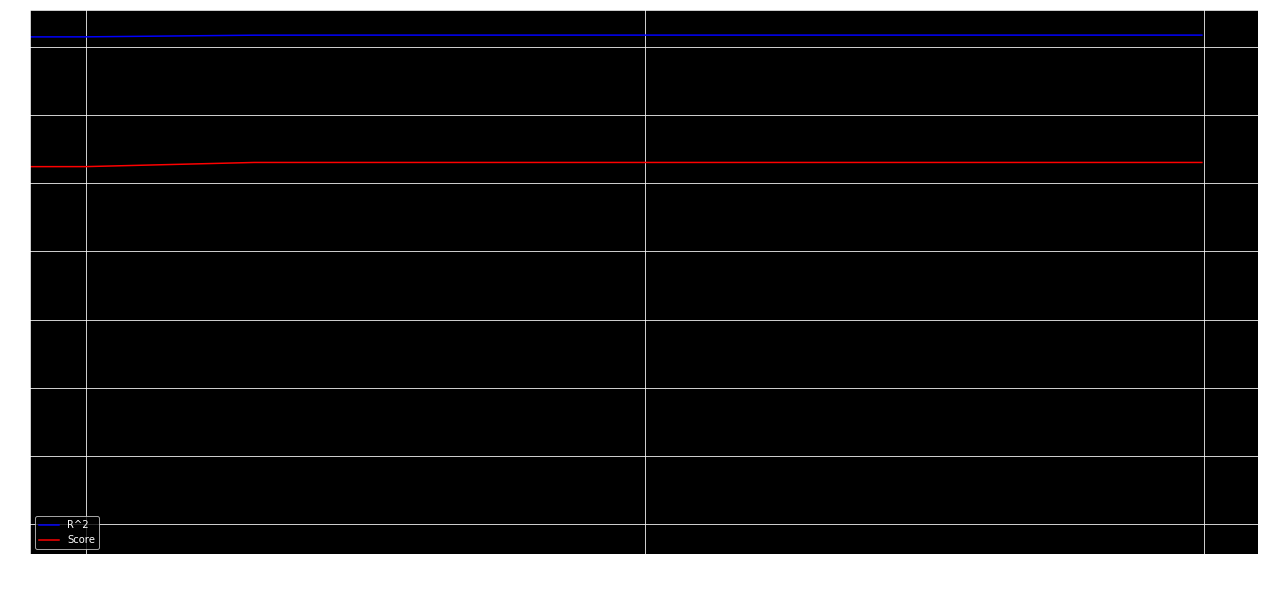

In [272]:
alphas = np.arange(0, 0.1, 0.001)
# alphas = np.linspace(0.0, 0.1, num=100)


def test_alpha(alpha):
    my_ridge = MyRidge(alpha=alpha, lmbda=200)

    my_ridge.fit(x_train, y_train)
    my_ridge_predictions = my_ridge.predict(x_test)

    my_ridge_r_square = my_ridge.r_square(y_test, my_ridge_predictions)

    score = my_ridge.score(x_train, y_train)

    return my_ridge_r_square, score


r2s = []
scores = []

for alpha in alphas:
    r2, score = test_alpha(alpha)
    r2s.append(r2)
    scores.append(score)

fig, ax = plt.subplots(1, 1, figsize=(22, 10))
ax.semilogx(alphas, (r2s), c='b', label='R^2')
ax.semilogx(alphas, (scores), c='r', label='Score')
ax.set_xlabel('alpha')
ax.legend(loc='best')
plt.grid()


 ### Test different lambdas

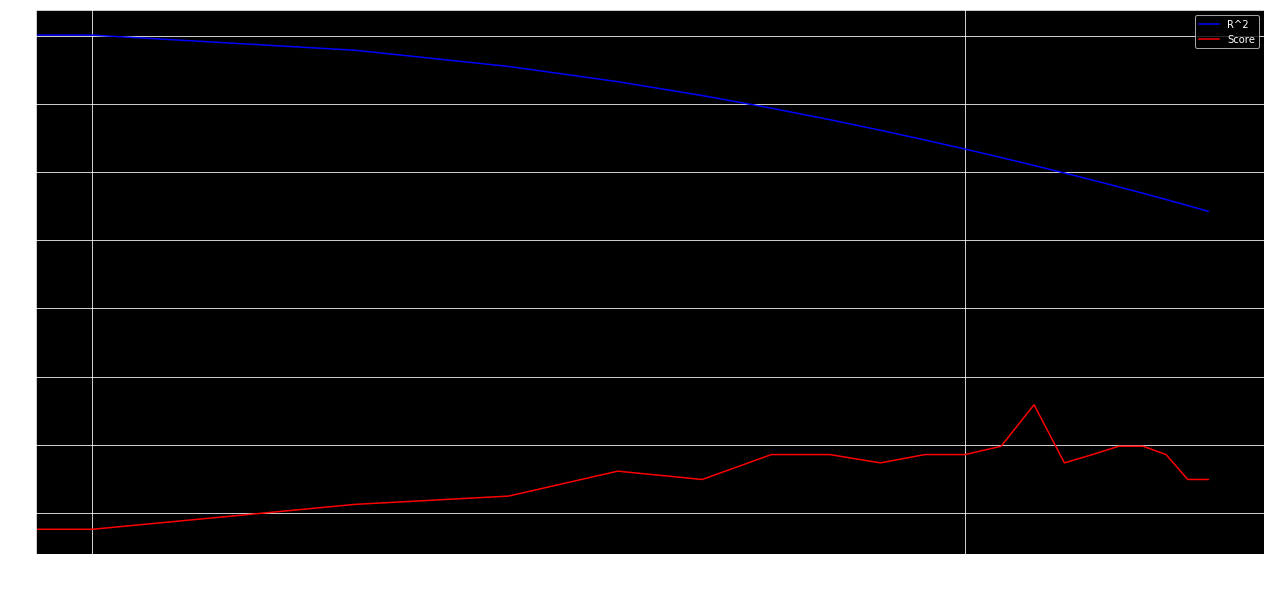

In [273]:
lambdas = range(0, 200, 10)


def test_lambda(lmbda):
    my_ridge = MyRidge(alpha=0.1, lmbda=lmbda)

    my_ridge.fit(x_train, y_train)
    my_ridge_predictions = my_ridge.predict(x_test)

    my_ridge_r_square = my_ridge.r_square(y_test, my_ridge_predictions)

    score = my_ridge.score(x_train, y_train)

    return my_ridge_r_square, score


r2s = []
scores = []

for lmbda in lambdas:
    r2, score = test_lambda(lmbda)
    r2s.append(r2)
    scores.append(score)

fig, ax = plt.subplots(1, 1, figsize=(22, 10))
ax.semilogx(lambdas, (r2s), c='b', label='R^2')
ax.semilogx(lambdas, (scores), c='r', label='Score')
ax.set_xlabel('$\lambda$')
ax.legend(loc='best')
plt.grid()


 ## Sklearn Simple Linear Regression

In [274]:
sklearn_linear_regression = LinearRegression()
sklearn_linear_regression.fit(x_train, y_train)
sklearn_linear_regression_predictions = sklearn_linear_regression.predict(
    x_test)
sklearn_linear_regression_predictions

sklearn_linear_regression_r_square_sklearn = r2_score(
    y_test, sklearn_linear_regression_predictions)
print('R^2:', sklearn_linear_regression_r_square_sklearn)

sklearn_linear_regression_score = sklearn_linear_regression.score(
    x_train, y_train)
print('Score:', sklearn_linear_regression_score)

sklearn_linear_regression_cross_validation = cross_validate(
    sklearn_linear_regression, x_test, y_test)
print('Cross validation:', sklearn_linear_regression_cross_validation)

sklearn_linear_regression_cross_validation_score = cross_val_score(
    sklearn_linear_regression, x_test, y_test)
print('Cross validation score:', sklearn_linear_regression_cross_validation_score)


R^2: 0.8486920456426336
Score: 0.886883690328956
Cross validation: {'fit_time': array([0.0010004, 0.       , 0.       ]), 'score_time': array([0.        , 0.00099945, 0.00100017]), 'test_score': array([ 0.7583841 ,  0.60796248, -1.27011814]), 'train_score': array([0.91030734, 0.8979543 , 0.9422434 ])}
Cross validation score: [ 0.7583841   0.60796248 -1.27011814]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


 ## Sklearn Ridge Regression using Stochastic Average Gradient

In [275]:
sklearn_ridge = Ridge(solver='sag')
sklearn_ridge.fit(x_train, y_train)
sklearn_ridge_predictions = sklearn_ridge.predict(x_test)
sklearn_ridge_predictions

sklearn_ridge_r_square_sklearn = r2_score(y_test, sklearn_ridge_predictions)
print('R^2:', sklearn_ridge_r_square_sklearn)

sklearn_ridge_score = sklearn_ridge.score(x_train, y_train)
print('Score:', sklearn_ridge_score)

sklearn_ridge_cross_validation = cross_validate(sklearn_ridge, x_test, y_test)
print('Cross validation:', sklearn_ridge_cross_validation)

sklearn_ridge_cross_validation_score = cross_val_score(
    sklearn_ridge, x_test, y_test)
print('Cross validation score:', sklearn_ridge_cross_validation_score)


R^2: 0.8513701602576184
Score: 0.8558953775806175
Cross validation: {'fit_time': array([0.00399852, 0.00199509, 0.00300074]), 'score_time': array([0.        , 0.00100112, 0.        ]), 'test_score': array([0.80931774, 0.83776055, 0.77158641]), 'train_score': array([0.89161636, 0.85238305, 0.86068185])}
Cross validation score: [0.80931246 0.83753884 0.77124484]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


 ## All in one

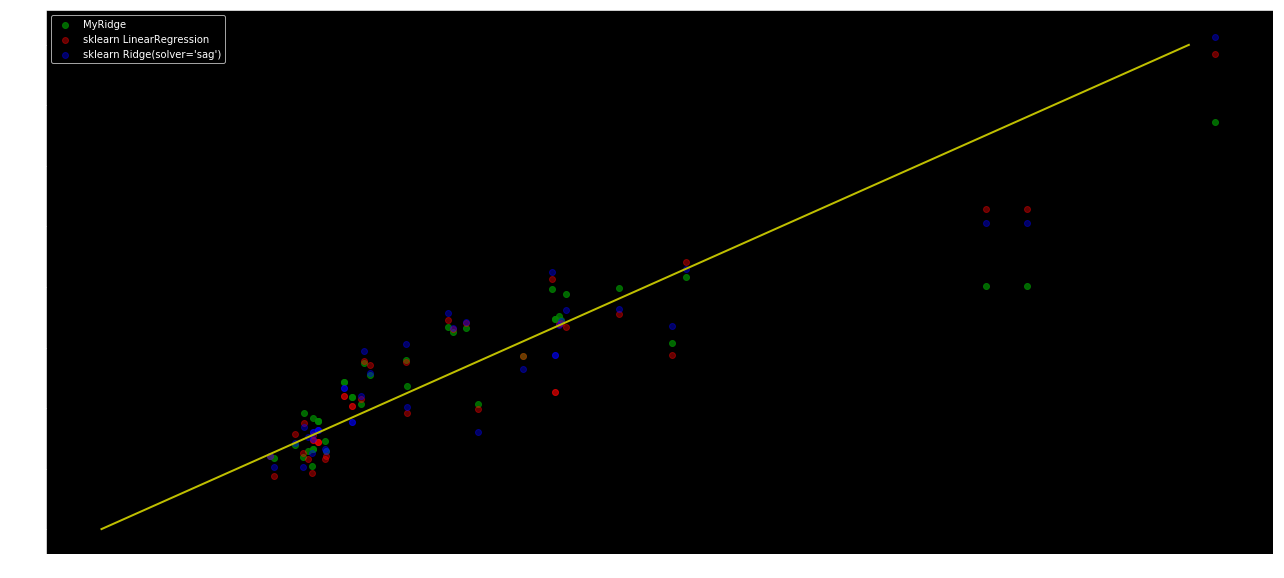

In [276]:
plt.figure(figsize=(22, 10))
plt.scatter(y_test, my_ridge_predictions,
            color='g', alpha=0.8, label='MyRidge')
plt.scatter(y_test, sklearn_linear_regression_predictions,
            color='r', alpha=0.4, label='sklearn LinearRegression')
plt.scatter(y_test, sklearn_ridge_predictions, color='b',
            alpha=0.4, label='sklearn Ridge(solver=\'sag\')')
plt.plot([0, 40000], [0, 40000], 'y-', lw=2)

plt.legend()
plt.show()


 ## MyRidge vs Sklearn's LinearRegression

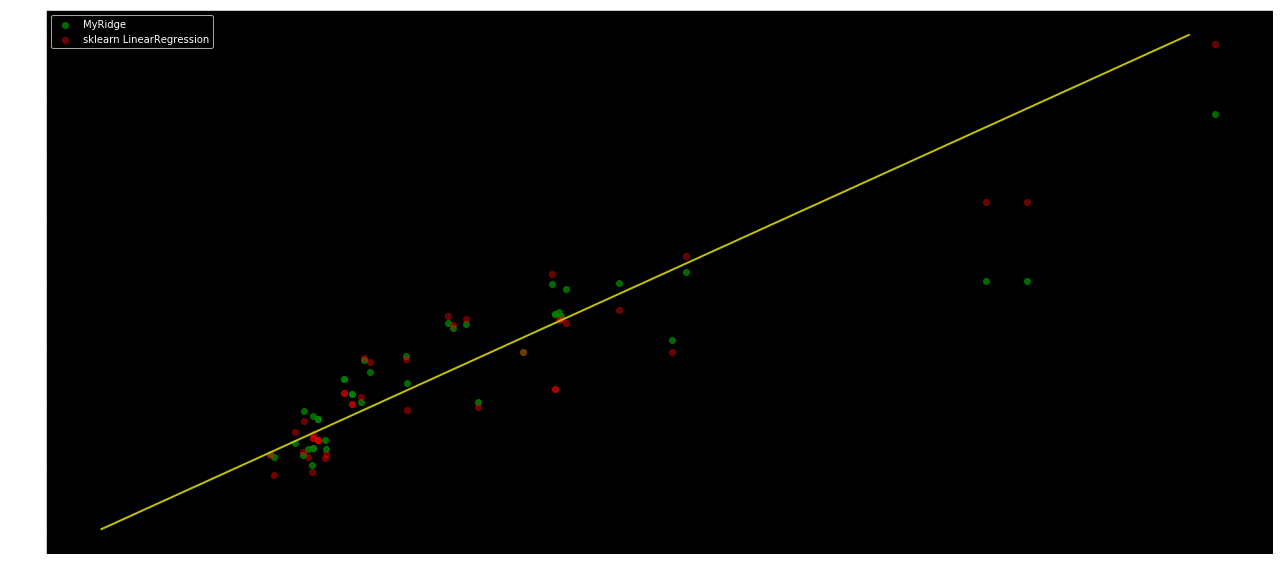

In [277]:
plt.figure(figsize=(22, 10))
plt.scatter(y_test, my_ridge_predictions,
            color='g', alpha=0.8, label='MyRidge')
plt.scatter(y_test, sklearn_linear_regression_predictions,
            color='r', alpha=0.4, label='sklearn LinearRegression')
plt.plot([0, 40000], [0, 40000], 'y-', lw=2)

plt.legend()
plt.show()



 ## MyRidge vs Sklearn's Ridge using Stochastic Average Gradient

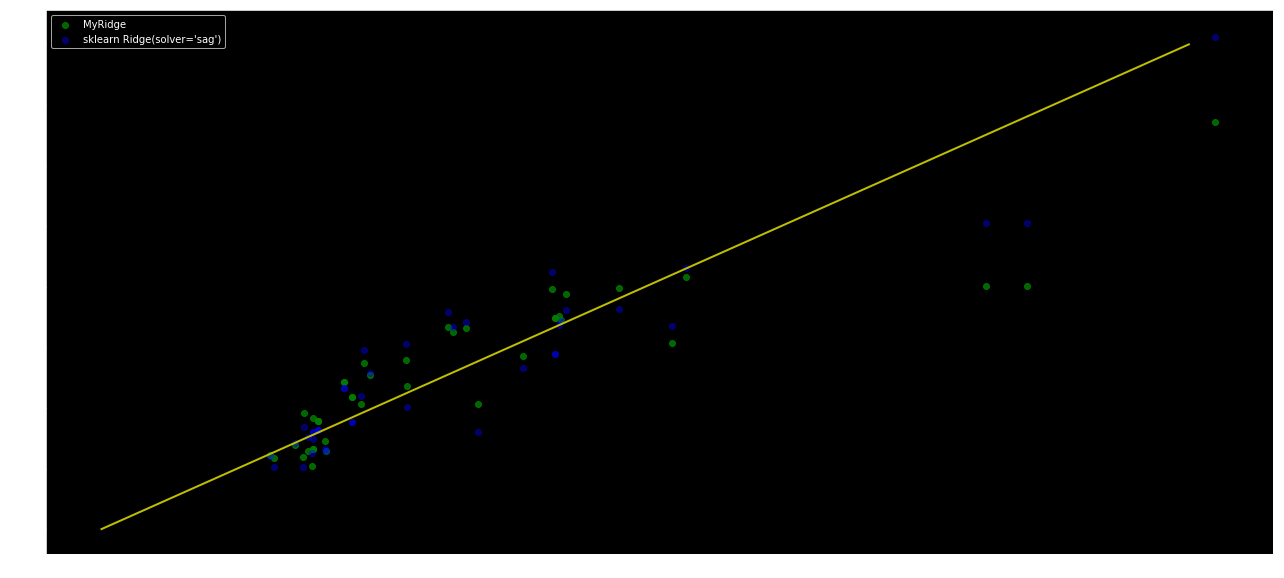

In [278]:
plt.figure(figsize=(22, 10))
plt.scatter(y_test, my_ridge_predictions,
            color='g', alpha=0.8, label='MyRidge')
plt.scatter(y_test, sklearn_ridge_predictions, color='b',
            alpha=0.4, label='sklearn Ridge(solver=\'sag\')')
plt.plot([0, 40000], [0, 40000], 'y-', lw=2)

plt.legend()
plt.show()



 ## Summary

 The results of MyRidge are not terrible, but definitely not satisfying. Event for the best parameters R^2 and CV scores were much worse than those of sklearn's Simple Linear Regression and Ridge Regression. Generally matching the techniques, I believe that the achieved results is good enough to 'trust' it.